In [5]:
from paths import models_folder, metadata_folder, latent_space_folder

In [6]:
from pyobsbox import ObsBoxGenerator

In [7]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [8]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [9]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_abs_diff_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_dense_512_128_32_8_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_max_pool_64_32_16_8_stride_4_B1H_Inst_center_scale_10

In [10]:
model_path = models_folder / "model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_znorm_rolling_avg_std_window_65_seed_42"

In [11]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_znorm_rolling_avg_std_window_65_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_znorm_rolling_avg_std_window_65_seed_42/train_fetched.npy')]

# Load model and associated generators

In [12]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"],
                                  return_meta=True)
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"],
                                       return_meta=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           960       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           14368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 8)              9

May/03 15:35:17 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
May/03 15:35:17 pyobsbox.generator INFO: ts_length: 63488
May/03 15:35:17 pyobsbox.generator INFO: shuffle: True
May/03 15:35:17 pyobsbox.generator INFO: seed: 42
May/03 15:35:17 pyobsbox.generator INFO: batch_size: 7936
May/03 15:35:17 pyobsbox.generator INFO: sequence_length: 2048
May/03 15:35:17 pyobsbox.generator INFO: n_bunches: 256
May/03 15:35:17 pyobsbox.generator INFO: __len__: 544
May/03 15:35:17 pyobsbox.generator INFO: fetched_log_folder: None
May/03 15:35:17 pyobsbox.generator INFO: fetched_log_prefix: 
May/03 15:35:17 pyobsbox.generator INFO: normalization: znorm
May/03 15:35:17 pyobsbox.generator INFO: normalization_pre_split: False
May/03 15:35:17 pyobsbox.generator INFO: normalization_kwargs: {}
May/03 15:35:17 pyobsbox.generator INFO: abs_diff: False
May/03 15:35:17 pyobsbox.generator INFO: diff: False
May/03 15:35:17 pyobsbox.g

In [13]:
print(train_metadata.shape)
train_metadata.head()

(139264, 11)


type  fill  beam plane  q           date_time  \
7245568  Inst  6254     1     h  7 2017-09-29 05:26:15   
6888832  Inst  6703     1     h  7 2018-05-20 03:39:14   
1617717  Inst  6663     1     h  7 2018-05-10 15:13:15   
6142098  Inst  6953     1     h  7 2018-07-21 06:32:07   
593944   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245568  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6254/...        292   
6888832  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6703/...        396   
1617717  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6142098  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
593944   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245568        228.0         115.0      65536  
6888832        161.0          86.0      65536  
1617717       1780.0        1306.0      65536  
6142098        455.0         316.0      65536  
593944        2807.0        1551.0      65536

In [14]:
print(validation_metadata.shape)
validation_metadata.head()

(1280, 11)


type  fill  beam plane  q           date_time  \
9990037  Inst  7448     1     h  7 2018-11-16 09:19:15   
4301710  Inst  7358     1     h  7 2018-10-26 09:09:46   
2175710  Inst  6627     1     h  7 2018-04-30 18:55:39   
9511941  Inst  6984     1     h  7 2018-07-26 21:29:07   
7641120  Inst  6429     1     h  7 2017-11-28 03:03:14   

                                                      file  n_bunches  \
9990037  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/...        648   
4301710  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7358/...         26   
2175710  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6627/...        637   
9511941  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6984/...        286   
7641120  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6429/...        332   

         bunch_index  bunch_number  ts_length  
9990037       2606.0         486.0      65536  
4301710       1645.0          16.0      65536  
2175710       1194.0         540.0      65536  
9511941       3107.0         275.0      65536  
7641120       1284.0         209.0      65536

# Loss functions

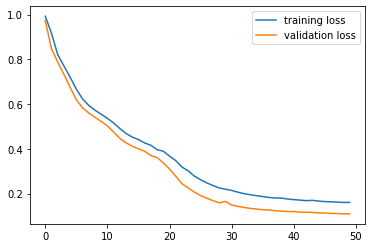

In [15]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [16]:
temp_train = [train_generator[i] for i in tqdm(range(50))]
train_dataset = np.vstack([data[0] for data in temp_train])
train_dataset.shape

bunch_sorted_index: [0 2 1]
group_bunches: [230. 428. 354.]
group_bunches sorted: [230. 354. 428.]
restore_index: [0 2 1]
group_bunches restored: [230. 428. 354.]
bunch_sorted_index: [0 1 2]
group_bunches: [2491. 2612. 2735.]
group_bunches sorted: [2491. 2612. 2735.]
restore_index: [0 1 2]
group_bunches restored: [2491. 2612. 2735.]
bunch_sorted_index: [1 3 2 0]
group_bunches: [2824.  483. 1923. 1492.]
group_bunches sorted: [ 483. 1492. 1923. 2824.]
restore_index: [3 0 2 1]
group_bunches restored: [2824.  483. 1923. 1492.]
bunch_sorted_index: [0 1 2]
group_bunches: [473. 683. 686.]
group_bunches sorted: [473. 683. 686.]
restore_index: [0 1 2]
group_bunches restored: [473. 683. 686.]



(396800, 2048, 2)

In [17]:
train_dataset_meta = pd.concat([meta[1] for meta in temp_train])
train_dataset_meta.shape

(396800, 12)

In [18]:
del temp_train

In [19]:
temp_validation = [validation_generator[i] for i in tqdm(range(5))]
validation_dataset = np.vstack([data[0] for data in temp_validation])
validation_dataset.shape

(39680, 2048, 2)

In [20]:
validation_dataset_meta = pd.concat([meta[1] for meta in temp_validation])
validation_dataset_meta.shape

(39680, 12)

In [21]:
del temp_validation

# Predictions

In [22]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 61s 1s/step


(396800, 2048, 2)

In [23]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 5s 999ms/step


(39680, 2048, 2)

In [24]:
MAE_train = abs(train_pred - train_dataset).mean(axis=(1, 2)).squeeze()
MAE_train.shape

(396800,)

In [25]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=(1, 2)).squeeze()
MAE_validation.shape

(39680,)

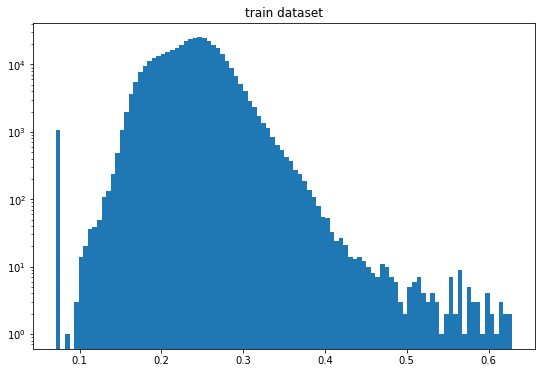

In [26]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [27]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.2441265205095394

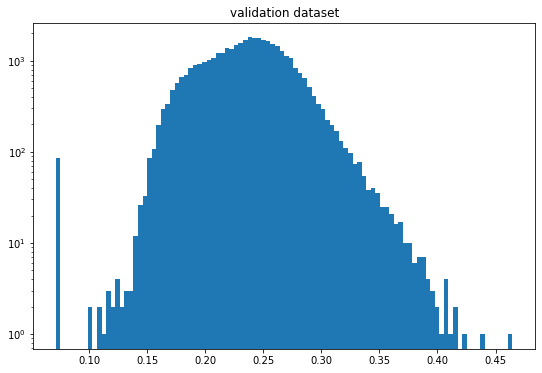

In [28]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [29]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.23635959560210146

In [30]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [31]:
max_MAE_indices

array([ 53710, 223308, 336441, ..., 365756, 257449, 147307])

In [32]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal[:, 0])
    axes[0].plot(pred_signal[:, 0])

    axes[1].plot(true_signal[:, 1])
    axes[1].plot(pred_signal[:, 1])
#     axes[1].plot(np.abs(np.diff(true_signal)))
#     axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

from pathlib import Path
from pyobsbox.utils import H5_PLANE_KEY
from pyobsbox import DB
import h5py

db = DB()

def load_plot(filepath: str, bunch_index: int):
    
    file_data = db._extract_columns(filepath)
    beam_key = "B{}".format(file_data["beam"])
    plane_key = H5_PLANE_KEY[file_data["plane"]]
    with h5py.File(filepath, "r") as h5_file:
        ob_data = h5_file[beam_key][plane_key]
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(ob_data[:, bunch_index])

index:  53710
MAE:  0.6292223927928438
n_bunches        156
bunch_index     1025
bunch_number     123
chunk              5
Name: 1511, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7383/instability_data/07383_Inst_B1H_Q7_20181029_02h15m14s.h5


(8192.0, 14336.0)

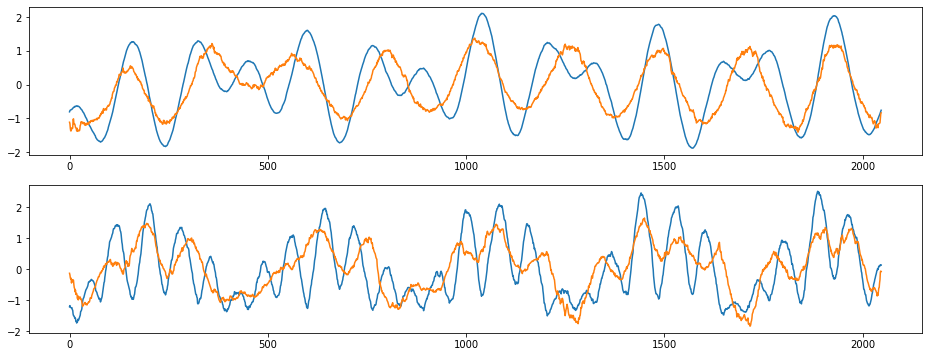

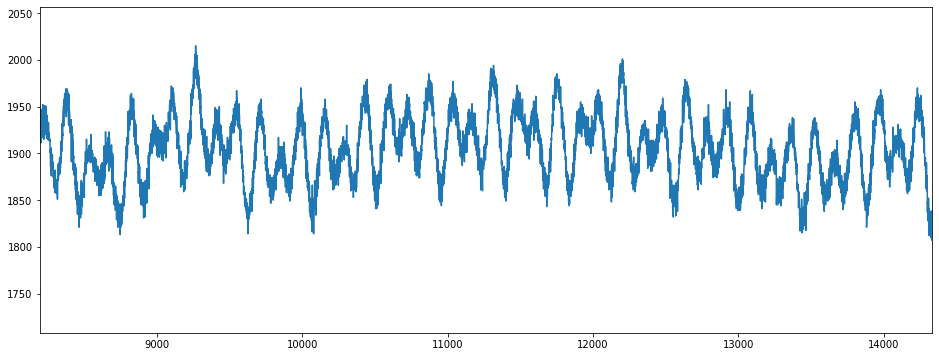

In [33]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_dataset_meta.iloc[anomalous_index]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal)
load_plot(metadata_row['file'], metadata_row['bunch_index'])

signal_chunk = metadata_row['chunk']
plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])

# Top rightmost signals

index:  53710
MAE:  0.6292223927928438
n_bunches        156
bunch_index     1025
bunch_number     123
chunk              5
Name: 1511, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7383/instability_data/07383_Inst_B1H_Q7_20181029_02h15m14s.h5


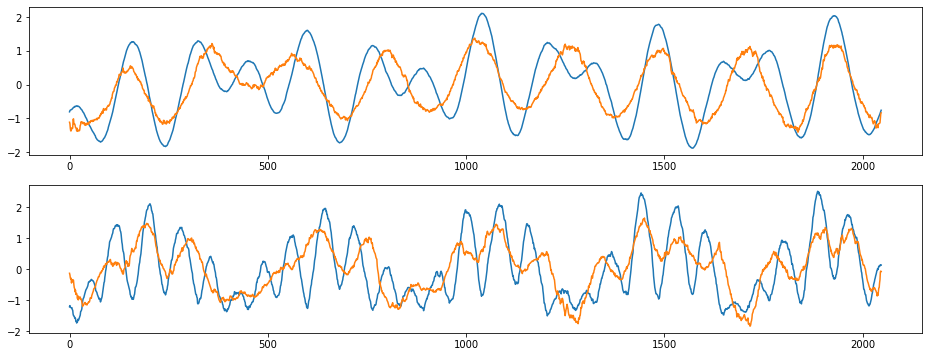

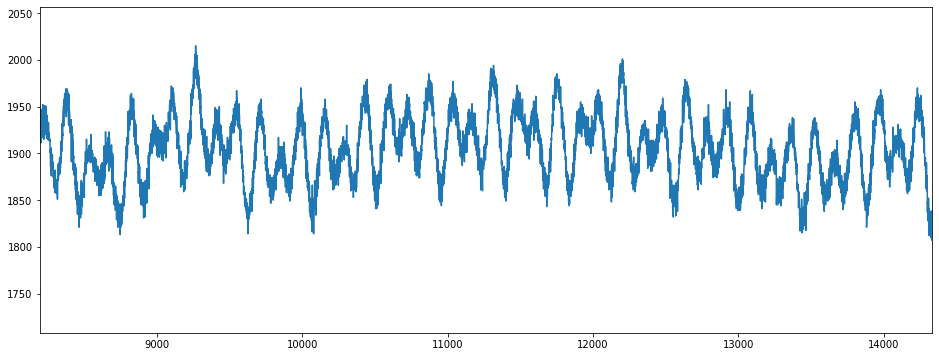

index:  223308
MAE:  0.6255281211416909
n_bunches       157
bunch_index     387
bunch_number    140
chunk            25
Name: 6436, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7362/instability_data/07362_Inst_B1H_Q7_20181026_16h18m45s.h5


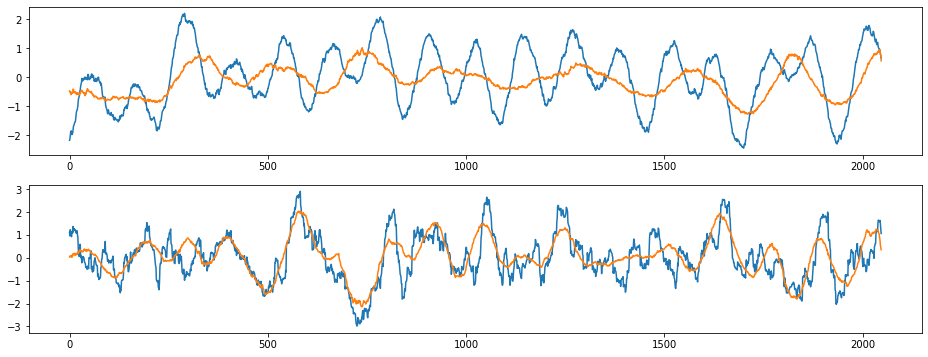

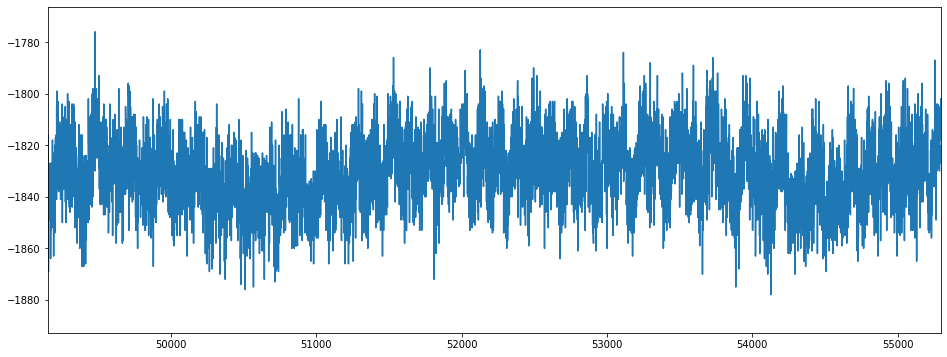

index:  336441
MAE:  0.620421669364508
n_bunches       300
bunch_index     446
bunch_number    211
chunk            15
Name: 3859, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7178/instability_data/07178_Inst_B1H_Q7_20180915_15h29m03s.h5


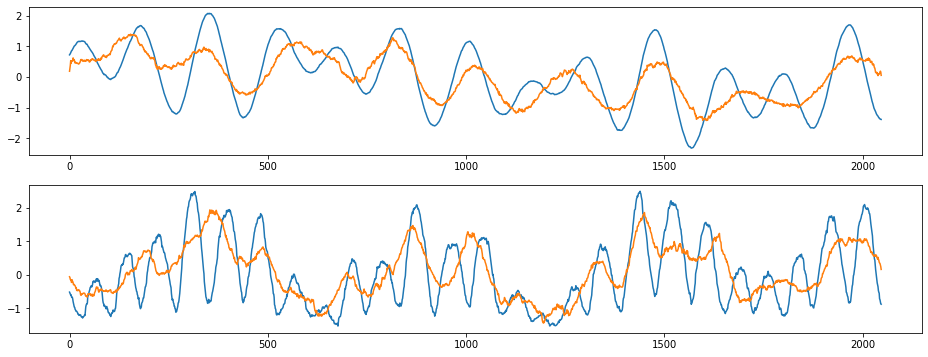

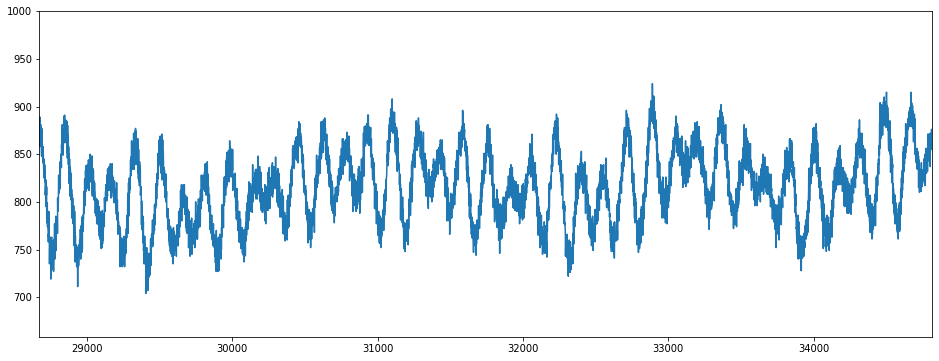

index:  339212
MAE:  0.6192718256844574
n_bunches       300
bunch_index     446
bunch_number    211
chunk            10
Name: 2579, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7178/instability_data/07178_Inst_B1H_Q7_20180915_15h29m03s.h5


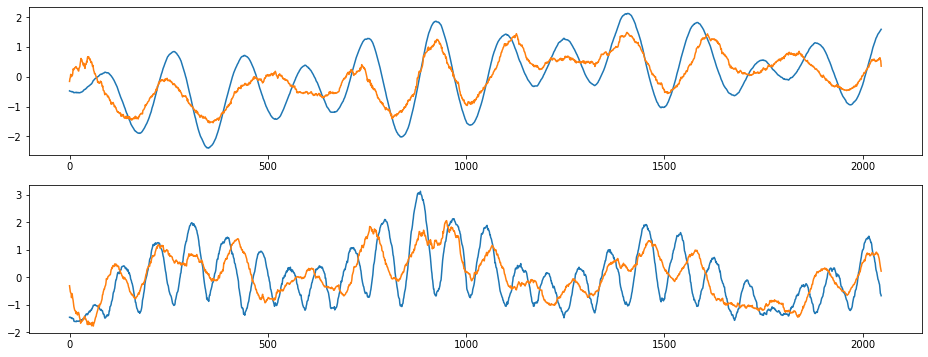

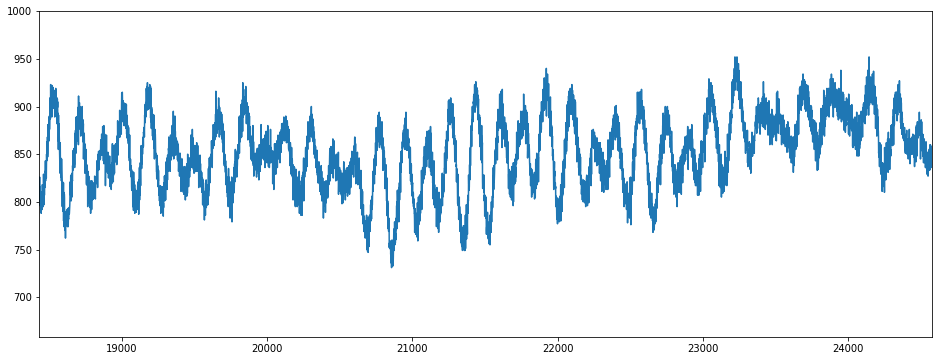

index:  337261
MAE:  0.617815994071478
n_bunches       300
bunch_index     446
bunch_number    211
chunk            24
Name: 6163, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7178/instability_data/07178_Inst_B1H_Q7_20180915_15h29m03s.h5


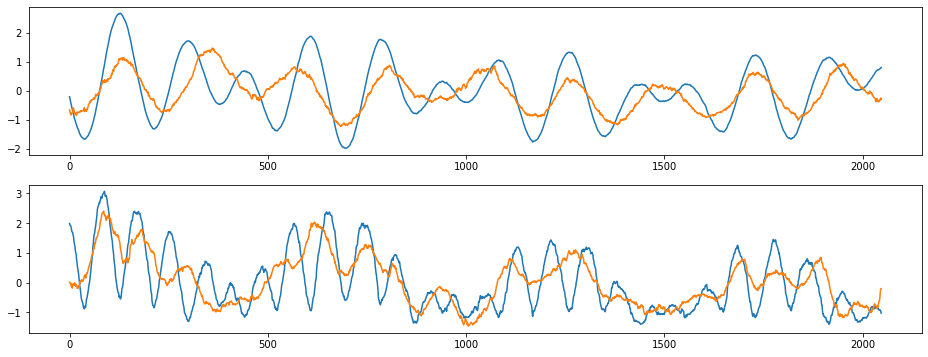

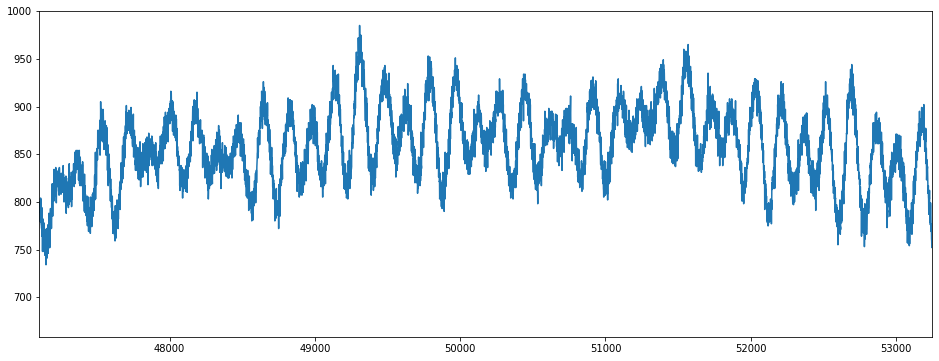

index:  339462
MAE:  0.6133852130287089
n_bunches       300
bunch_index     446
bunch_number    211
chunk            26
Name: 6675, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7178/instability_data/07178_Inst_B1H_Q7_20180915_15h29m03s.h5


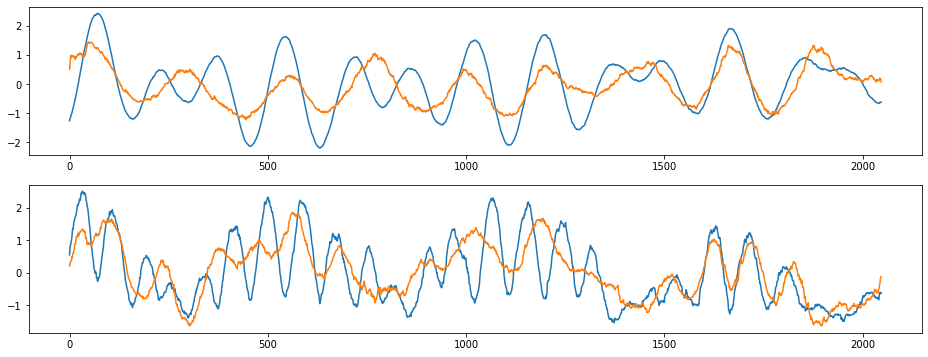

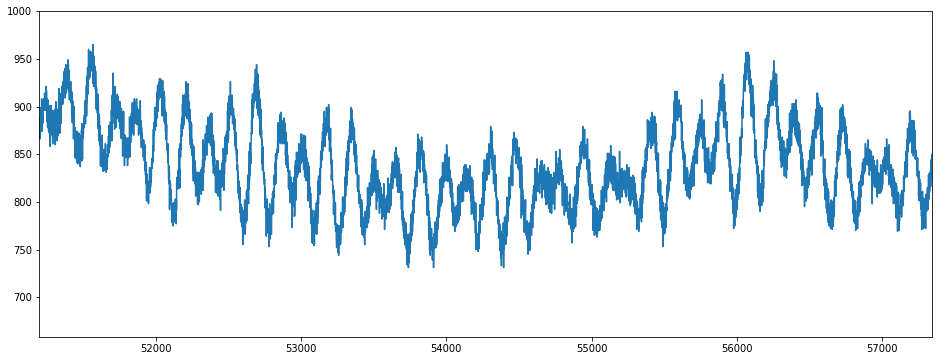

index:  340936
MAE:  0.6128277057867735
n_bunches       300
bunch_index     446
bunch_number    211
chunk             7
Name: 1811, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7178/instability_data/07178_Inst_B1H_Q7_20180915_15h29m03s.h5


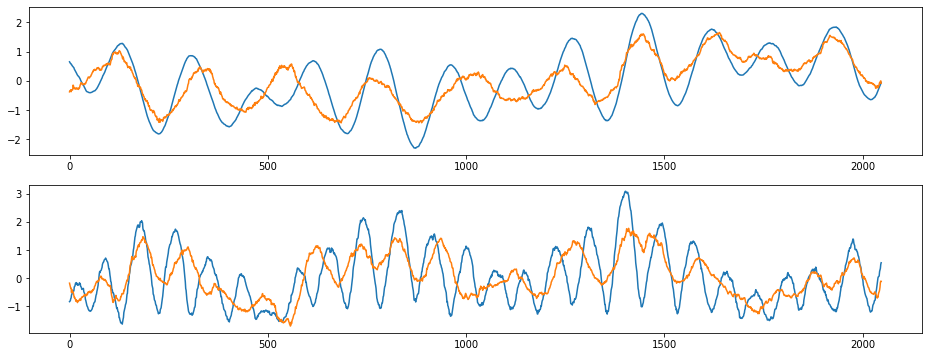

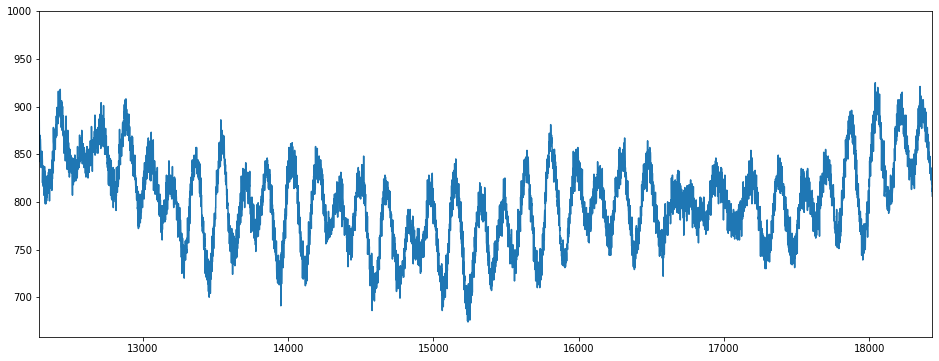

index:  53714
MAE:  0.6104844156690927
n_bunches        156
bunch_index     1025
bunch_number     123
chunk              7
Name: 2023, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7383/instability_data/07383_Inst_B1H_Q7_20181029_02h15m14s.h5


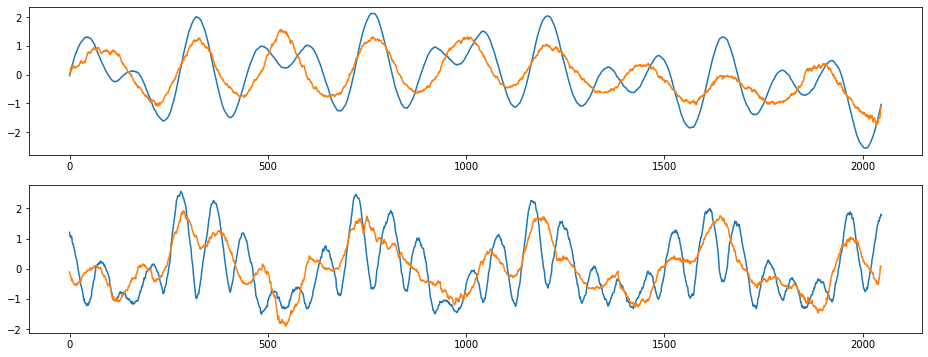

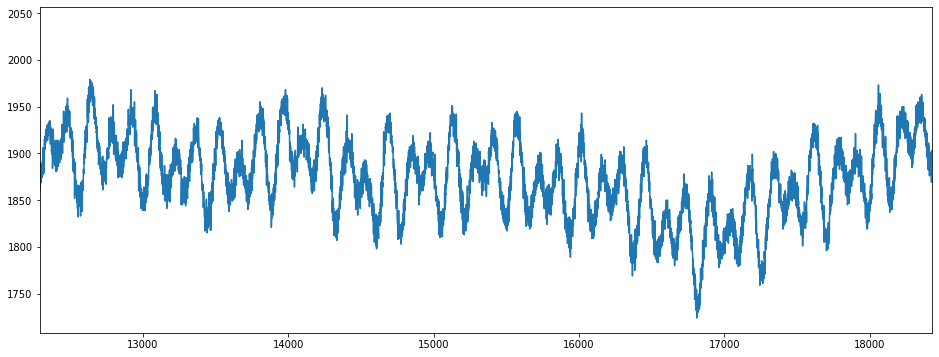

index:  337374
MAE:  0.6055030148408225
n_bunches       300
bunch_index     446
bunch_number    211
chunk            29
Name: 7443, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7178/instability_data/07178_Inst_B1H_Q7_20180915_15h29m03s.h5


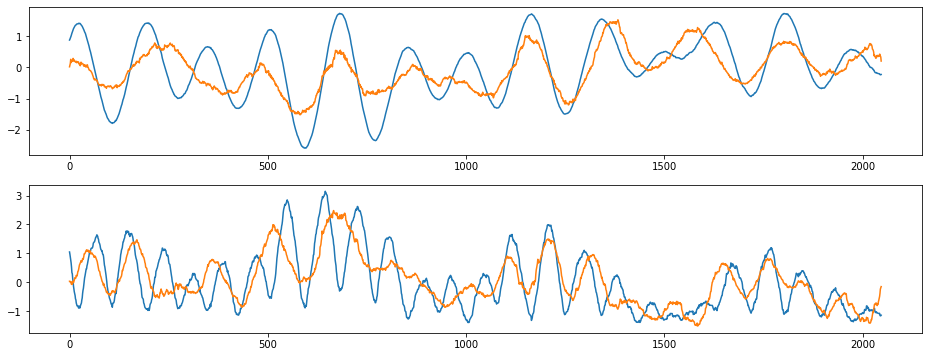

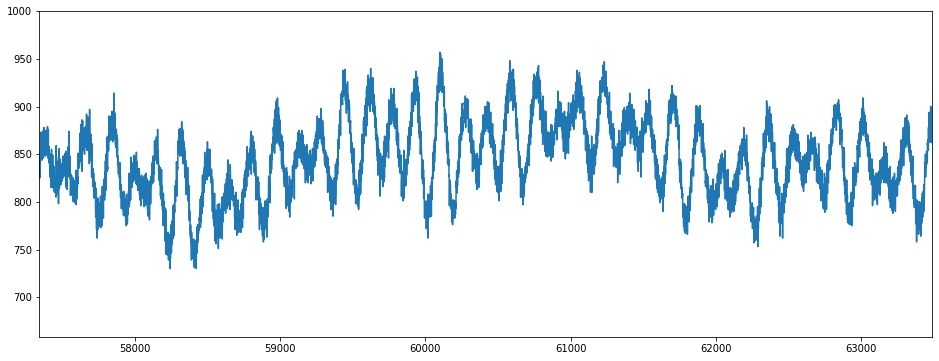

index:  339043
MAE:  0.6038378404616225
n_bunches       300
bunch_index     446
bunch_number    211
chunk             1
Name: 275, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7178/instability_data/07178_Inst_B1H_Q7_20180915_15h29m03s.h5


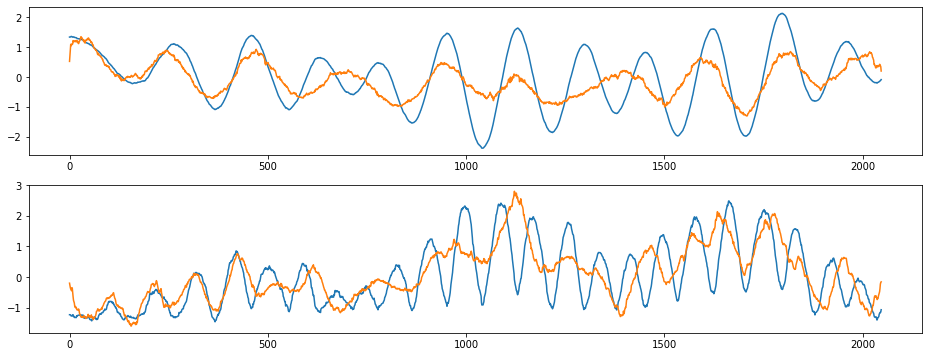

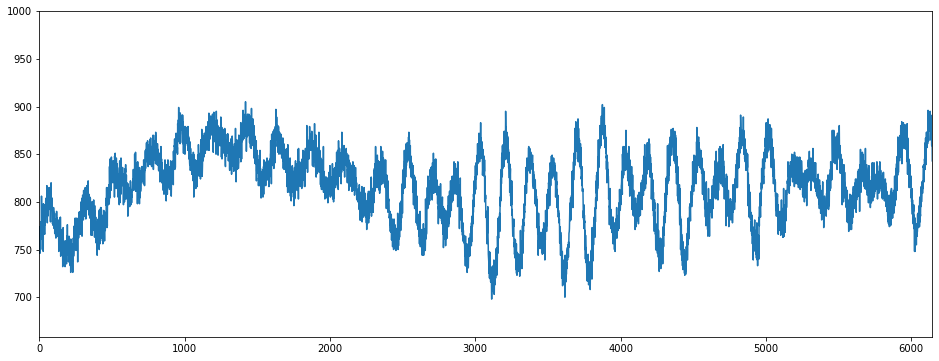

In [34]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# Top leftmost signals

index:  147307
MAE:  0.0711124329619679
n_bunches        924
bunch_index     1135
bunch_number     826
chunk             17
Name: 4371, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7239/instability_data/07239_Inst_B1H_Q7_20180930_12h13m34s.h5


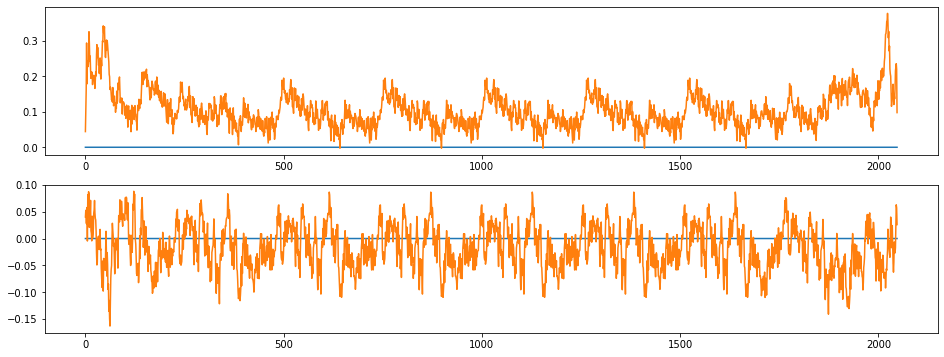

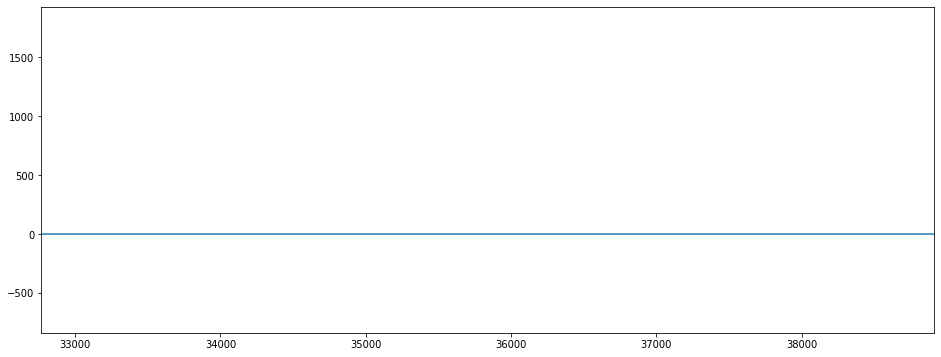

index:  257449
MAE:  0.0711124329619679
n_bunches       108
bunch_index     103
bunch_number     54
chunk             1
Name: 336, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7328/instability_data/07328_Inst_B1H_Q7_20181021_21h51m14s.h5


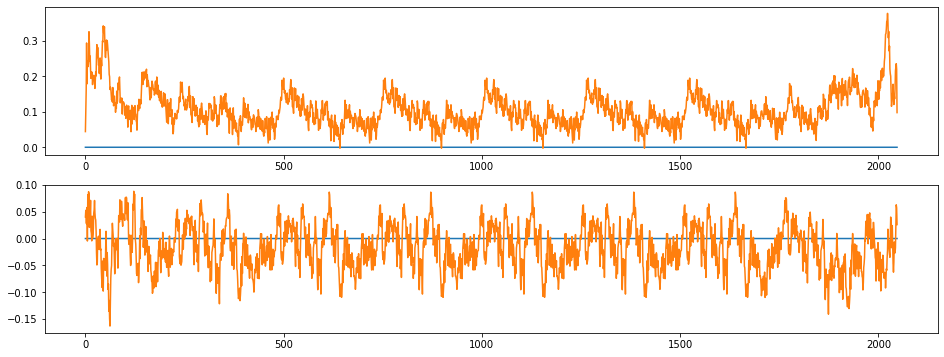

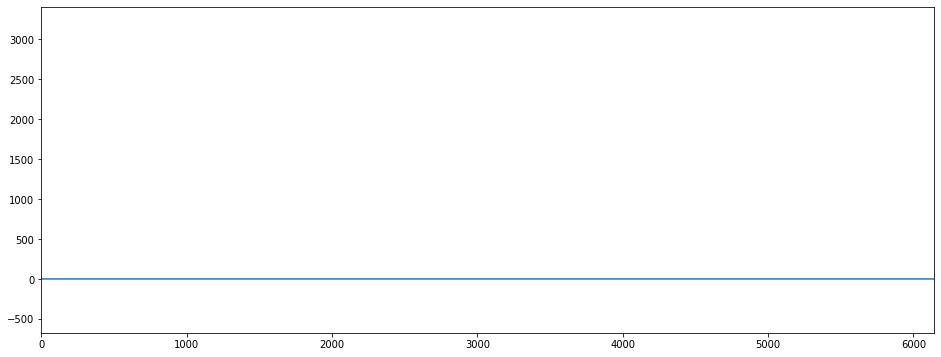

index:  365756
MAE:  0.0711124329619679
n_bunches       428
bunch_index     772
bunch_number    427
chunk             0
Name: 72, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6415/instability_data/06415_Inst_B1H_Q7_20171125_04h14m41s.h5


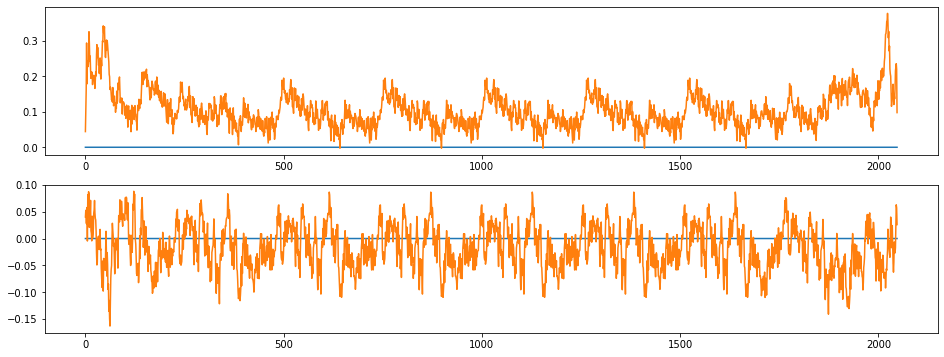

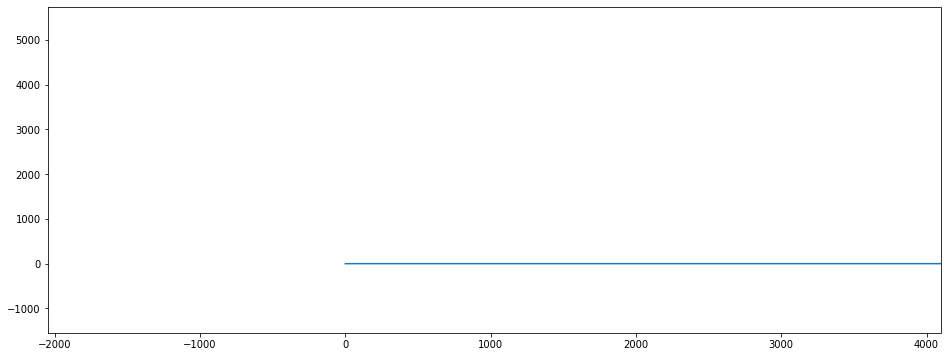

index:  147273
MAE:  0.0711124329619679
n_bunches       108
bunch_index     401
bunch_number     27
chunk             8
Name: 2101, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7314/instability_data/07314_Inst_B1H_Q7_20181017_23h05m11s.h5


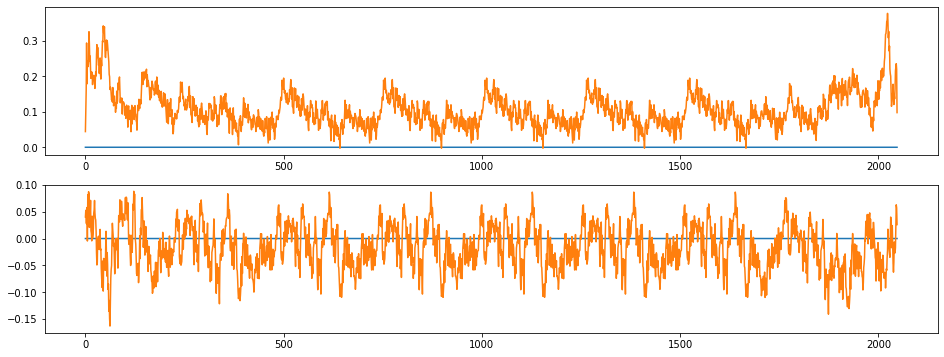

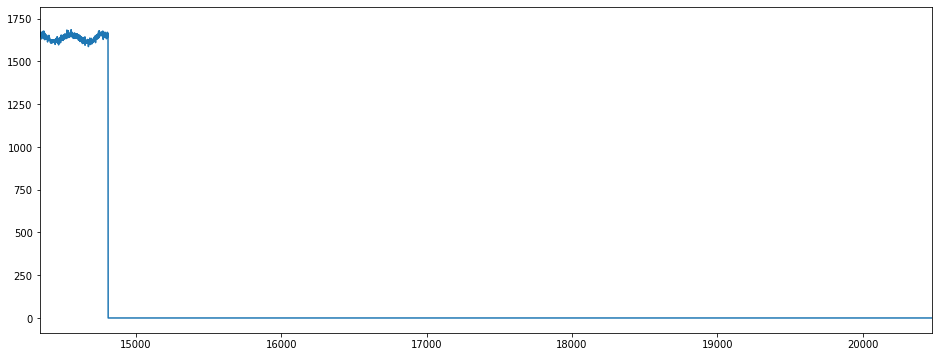

index:  20536
MAE:  0.0711124329619679
n_bunches       372
bunch_index     144
bunch_number     47
chunk            22
Name: 5790, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6572/instability_data/06572_Inst_B1H_Q7_20180417_23h11m08s.h5


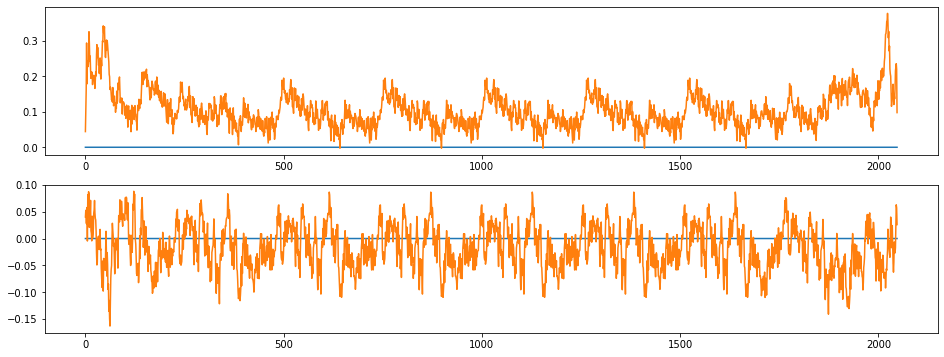

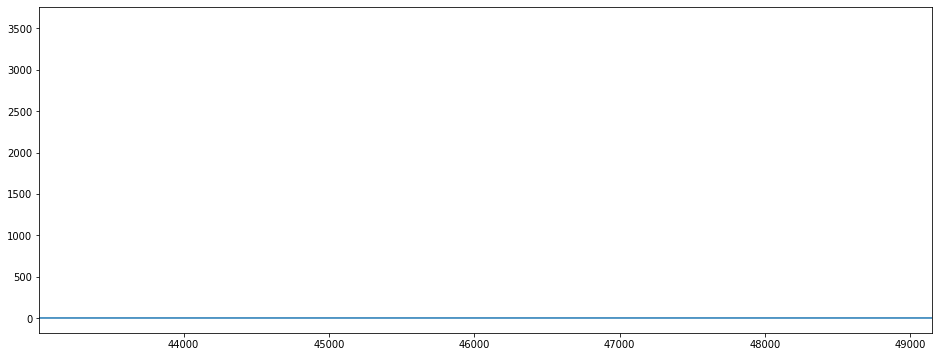

index:  178342
MAE:  0.0711124329619679
n_bunches        652
bunch_index     1131
bunch_number     607
chunk              2
Name: 644, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6351/instability_data/06351_Inst_B1H_Q7_20171031_15h14m18s.h5


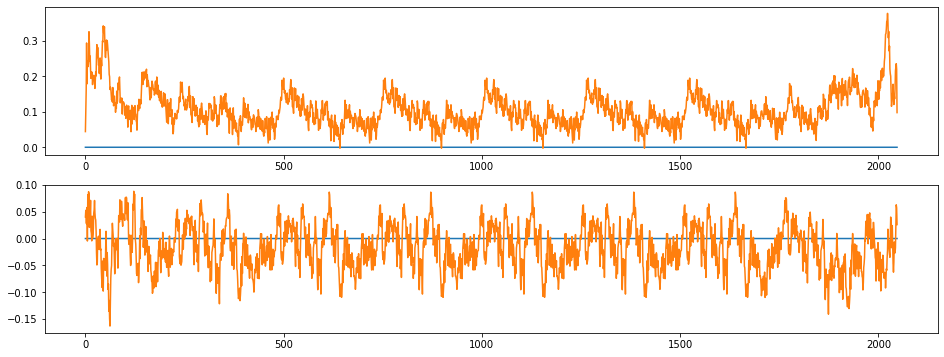

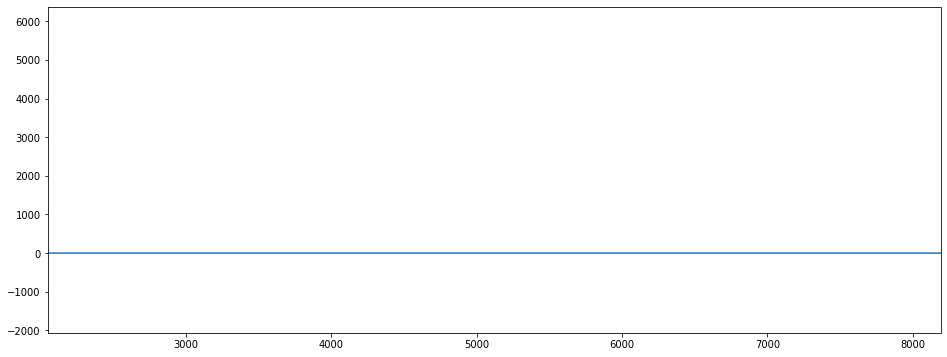

index:  226453
MAE:  0.0711124329619679
n_bunches        924
bunch_index     1097
bunch_number     788
chunk              5
Name: 1313, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7035/instability_data/07035_Inst_B1H_Q7_20180807_16h51m37s.h5


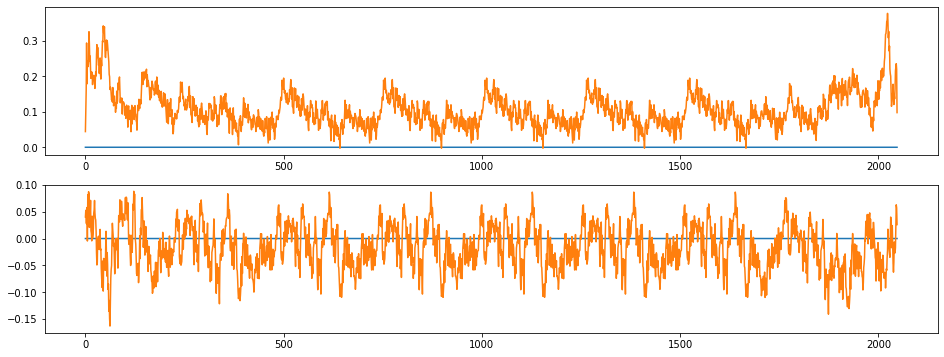

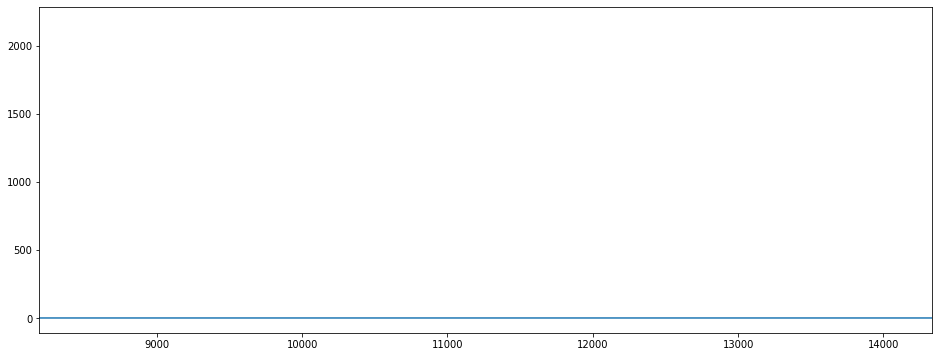

index:  56588
MAE:  0.0711124329619679
n_bunches        372
bunch_index     1977
bunch_number     370
chunk             16
Name: 4144, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7454/instability_data/07454_Inst_B1H_Q7_20181118_23h27m14s.h5


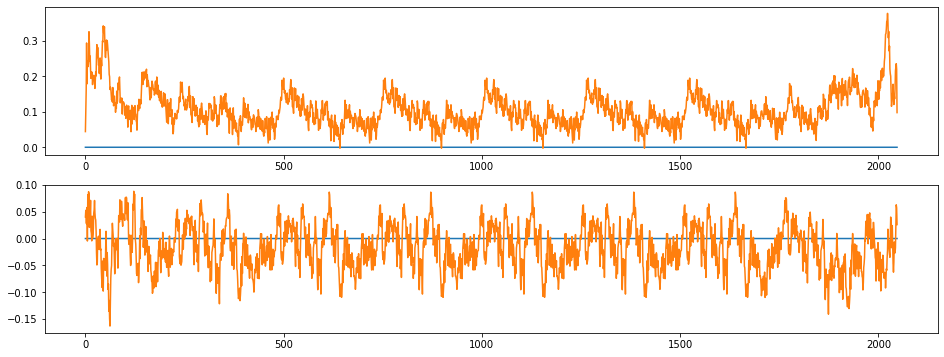

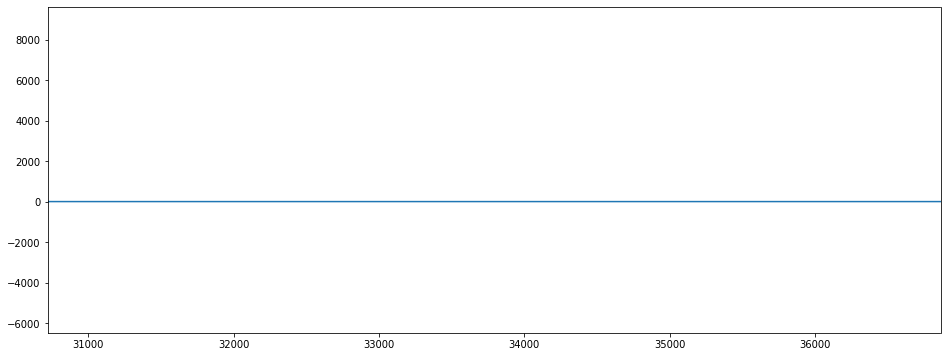

index:  42372
MAE:  0.0711124329619679
n_bunches        620
bunch_index     1016
bunch_number     504
chunk              0
Name: 199, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6390/instability_data/06390_Inst_B1H_Q7_20171115_15h35m30s.h5


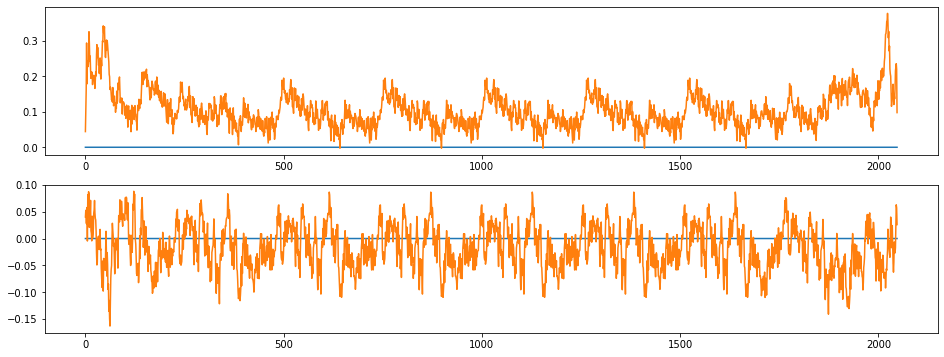

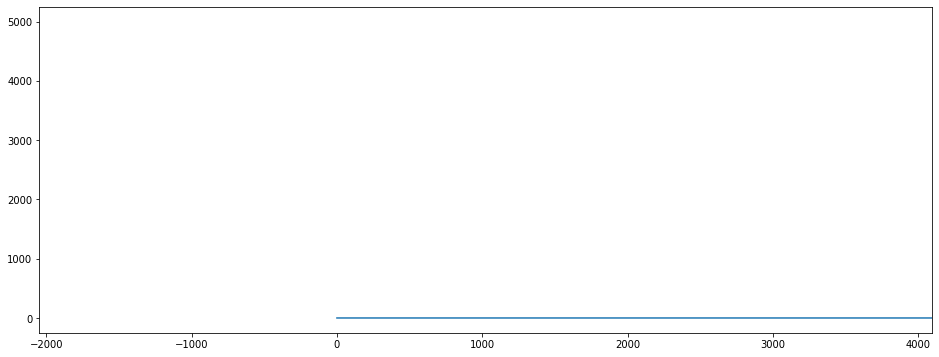

index:  175964
MAE:  0.0711124329619679
n_bunches        271
bunch_index     1164
bunch_number     243
chunk              8
Name: 2161, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7490/instability_data/07490_Inst_B1H_Q7_20181201_20h25m38s.h5


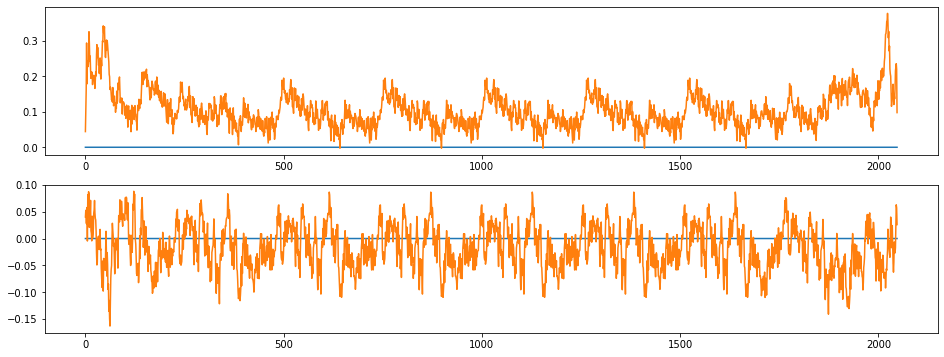

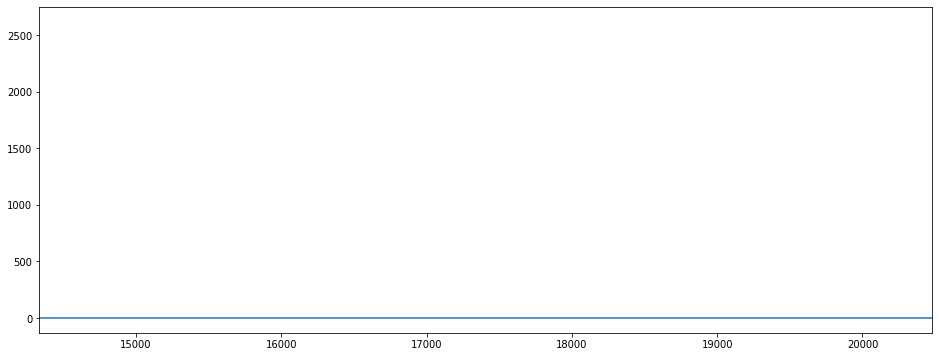

In [35]:
for i in range(1, 11):
    left_most = -i
    anomalous_index = max_MAE_indices[left_most]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# Signals around the peak

In [36]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  298340
MAE:  0.2441268243602679
n_bunches       2556
bunch_index      264
bunch_number     170
chunk             27
Name: 7056, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7135/instability_data/07135_Inst_B1H_Q7_20180907_19h39m14s.h5


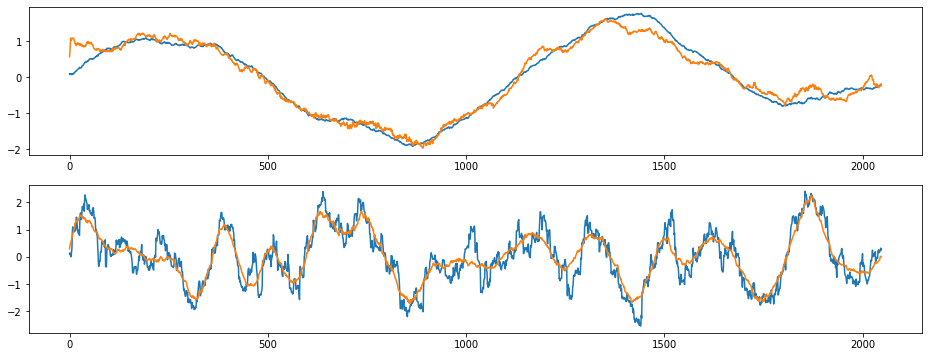

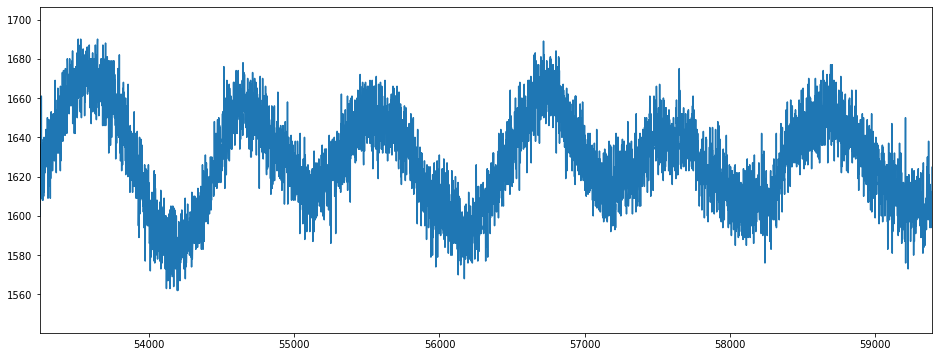

index:  243656
MAE:  0.24412688410356692
n_bunches       1916
bunch_index     2905
bunch_number    1598
chunk              5
Name: 1430, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_09h03m14s.h5


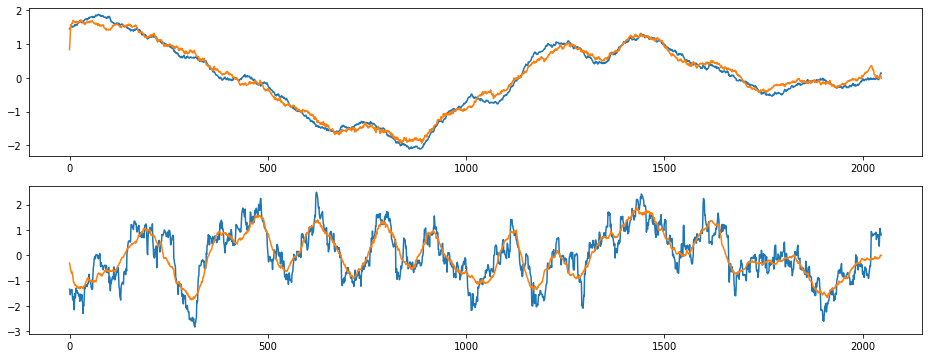

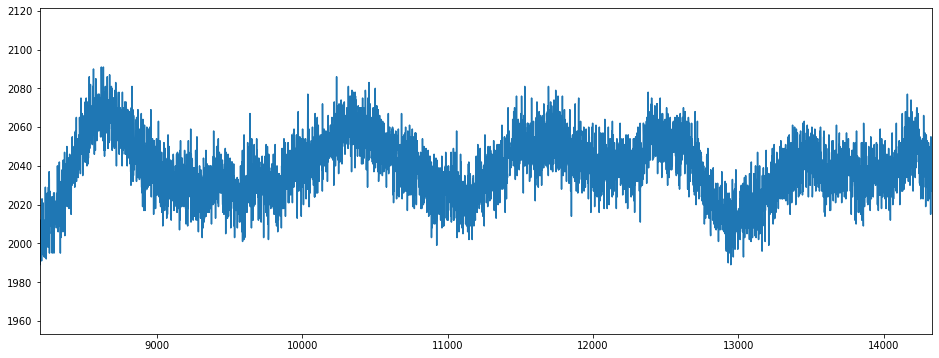

index:  44501
MAE:  0.2441268974298279
n_bunches       2556
bunch_index     3207
bunch_number    2376
chunk             10
Name: 2683, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6654/instability_data/06654_Inst_B1H_Q7_20180508_01h30m13s.h5


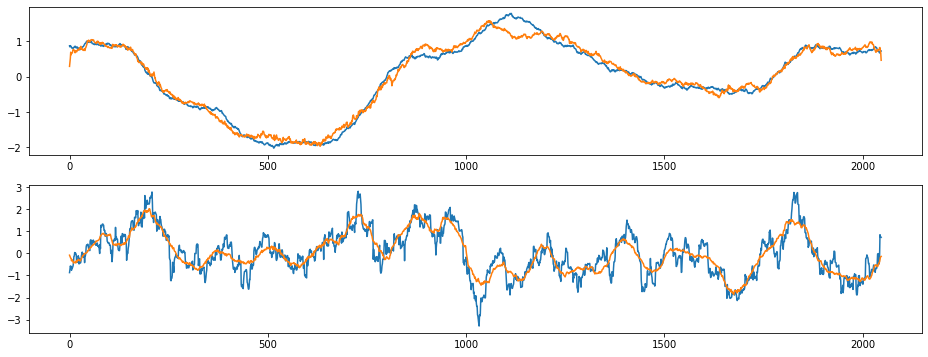

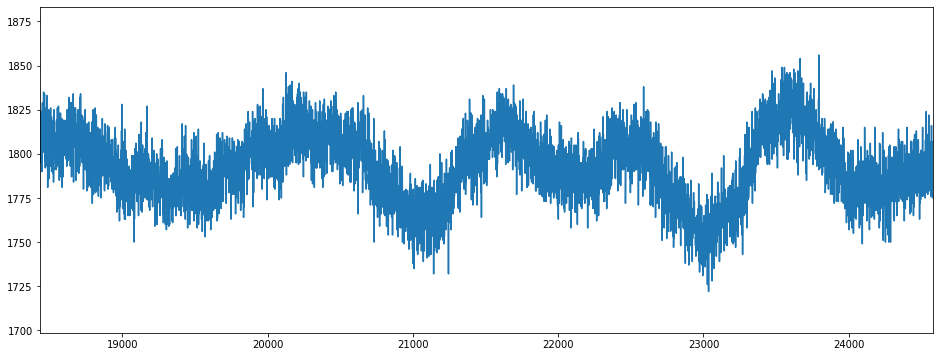

index:  118538
MAE:  0.24412704541940378
n_bunches        987
bunch_index     3126
bunch_number     845
chunk              2
Name: 624, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6688/instability_data/06688_Inst_B1H_Q7_20180515_21h21m14s.h5


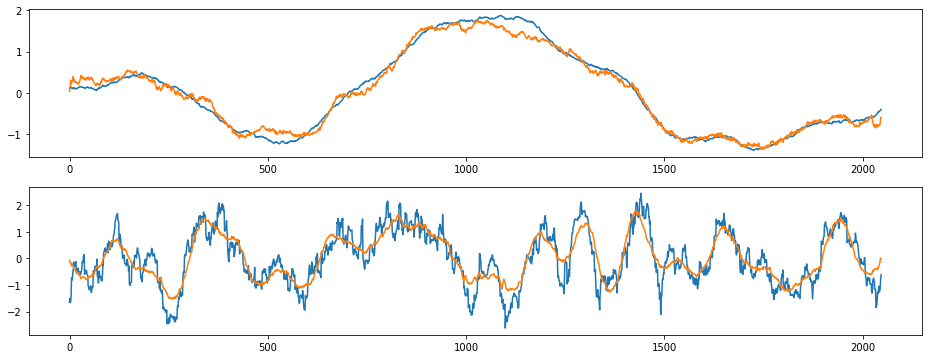

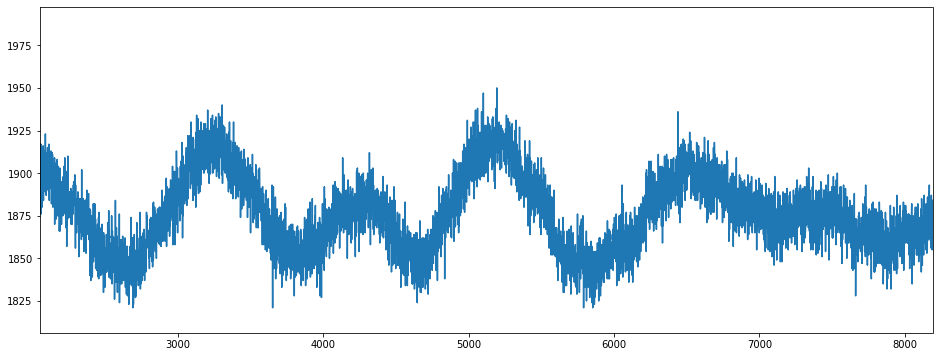

index:  379819
MAE:  0.24412586992688684
n_bunches       1868
bunch_index      491
bunch_number     265
chunk             17
Name: 4568, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6279/instability_data/06279_Inst_B1H_Q7_20171007_10h42m14s.h5


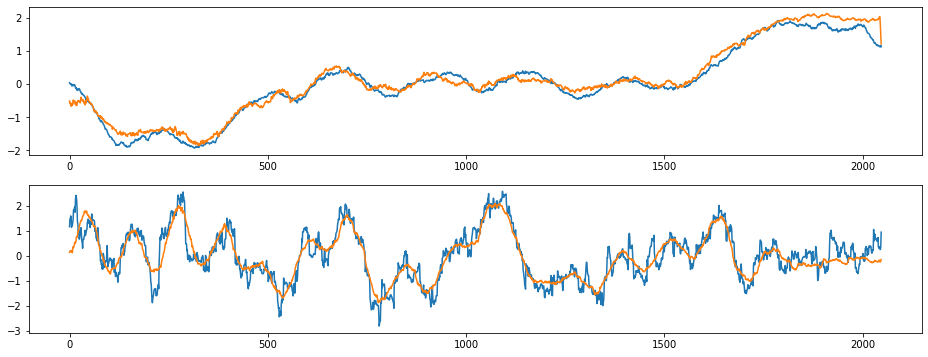

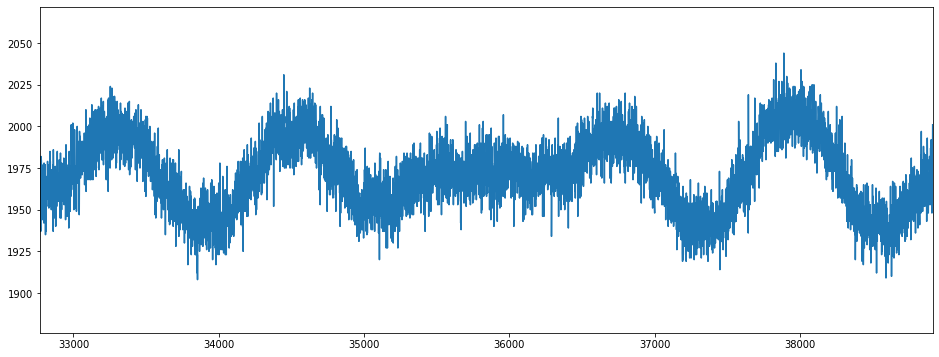

index:  227634
MAE:  0.24412577044543032
n_bunches       1358
bunch_index     1086
bunch_number     374
chunk             22
Name: 5813, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_05h05m14s.h5


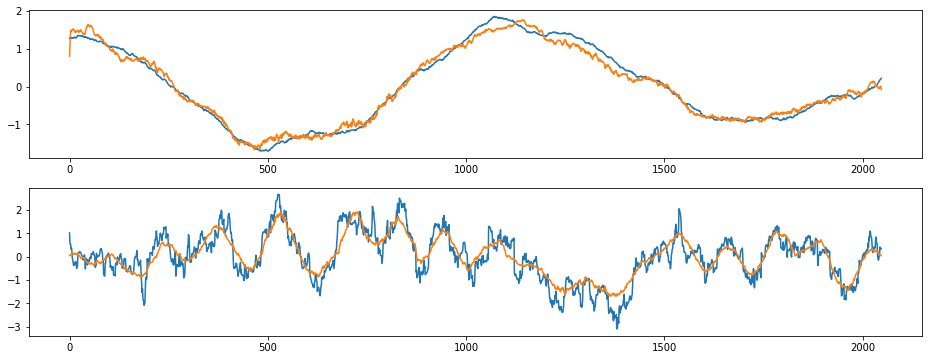

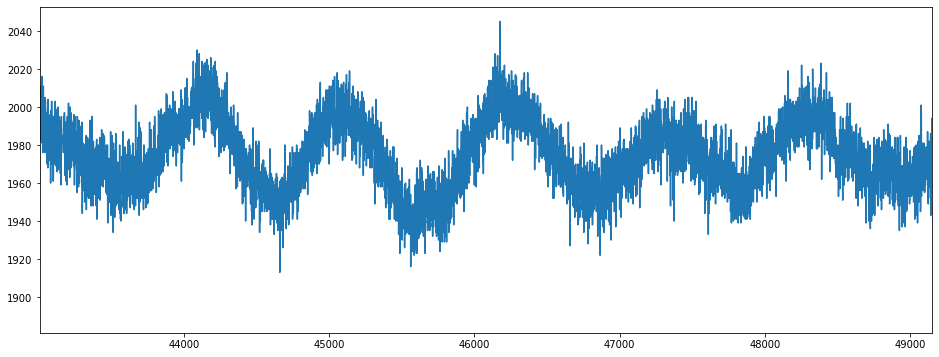

index:  269766
MAE:  0.24412745245391443
n_bunches        228
bunch_index     1502
bunch_number     114
chunk             13
Name: 3398, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6220/instability_data/06220_Inst_B1H_Q7_20170917_22h16m41s.h5


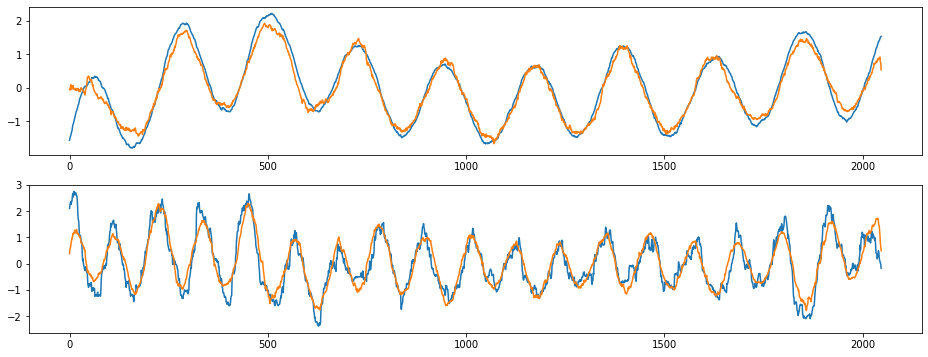

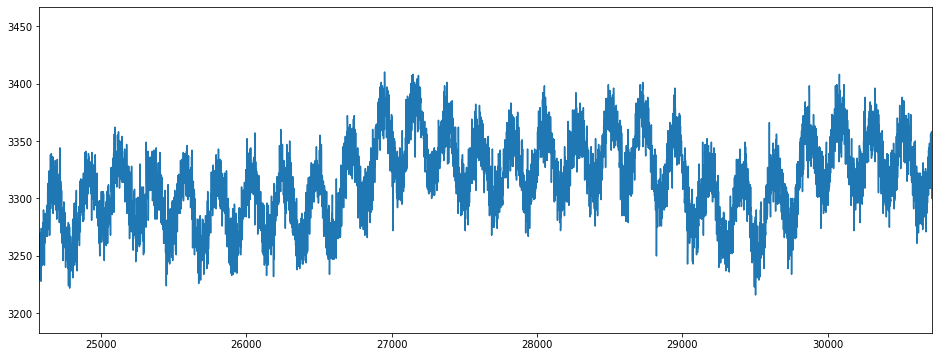

index:  90621
MAE:  0.24412751429214388
n_bunches       108
bunch_index     161
bunch_number    105
chunk            24
Name: 6253, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6787/instability_data/06787_Inst_B1H_Q7_20180613_19h12m50s.h5


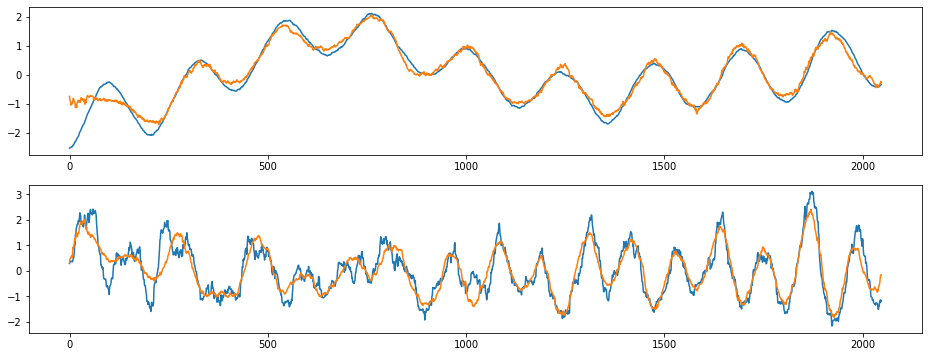

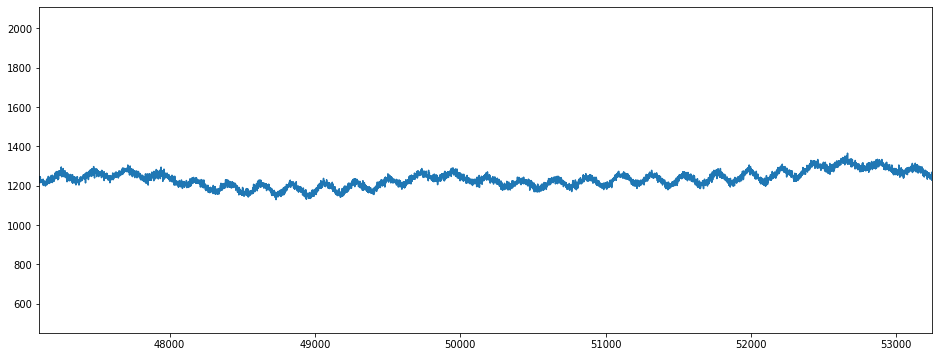

index:  85427
MAE:  0.2441276004090265
n_bunches       1452
bunch_index      472
bunch_number     186
chunk             17
Name: 4359, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_22h46m14s.h5


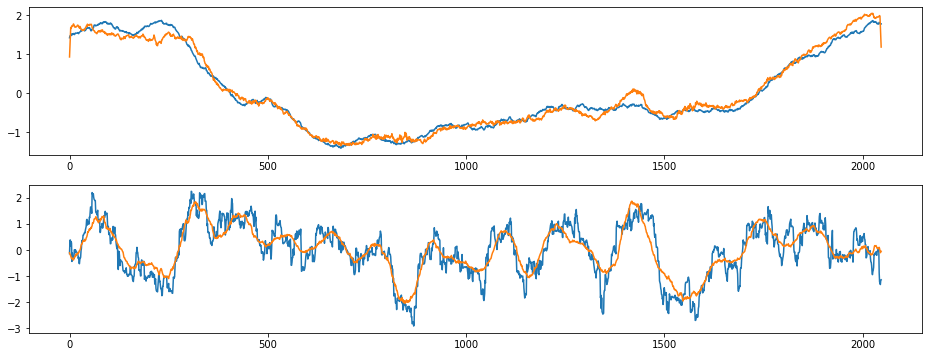

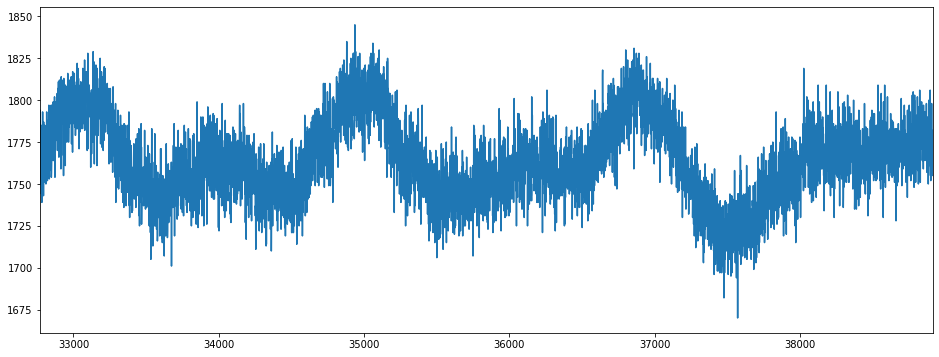

index:  271268
MAE:  0.24412505730774411
n_bunches       252
bunch_index     100
bunch_number     51
chunk             8
Name: 2187, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7347/instability_data/07347_Inst_B1H_Q7_20181025_10h16m01s.h5


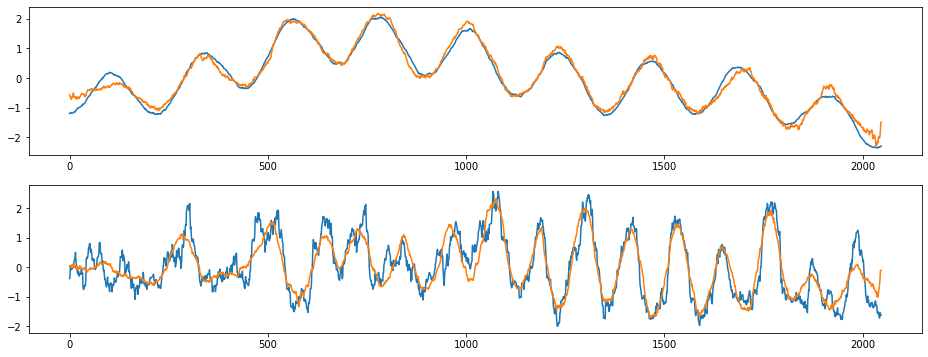

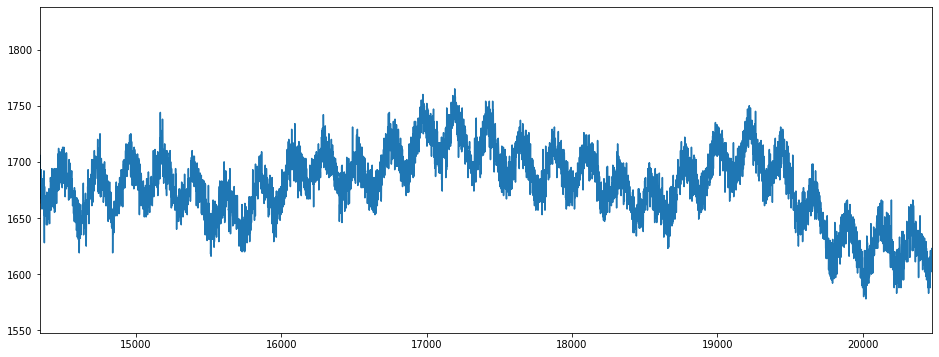

In [37]:
for i in range(10):
    anomalous_index = around_peak_indices[i]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# around a point

In [38]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.1))

index:  42472
MAE:  0.10006582172126653
n_bunches       396
bunch_index     521
bunch_number    375
chunk            11
Name: 3022, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7256/instability_data/07256_Inst_B1H_Q7_20181004_02h40m41s.h5


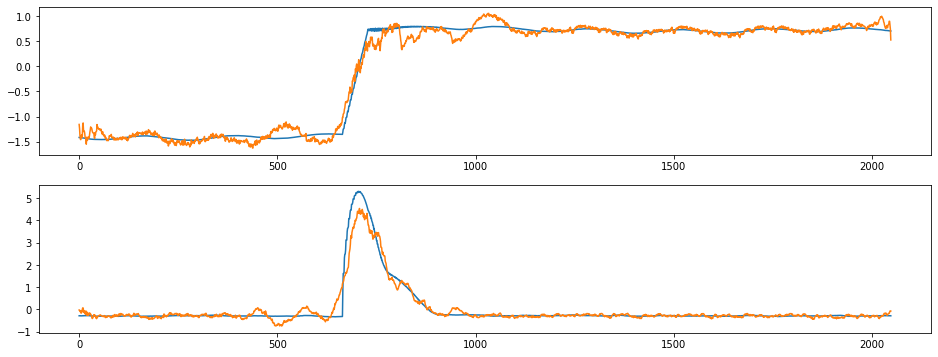

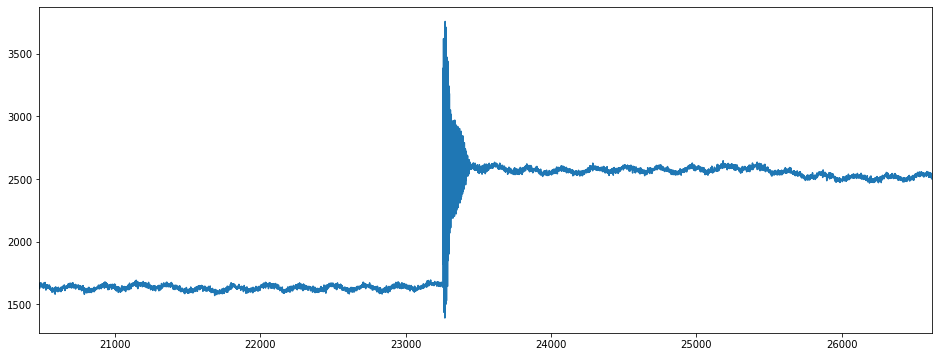

index:  155257
MAE:  0.10049482898681246
n_bunches       924
bunch_index     350
bunch_number    249
chunk            11
Name: 3071, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6909/instability_data/06909_Inst_B1H_Q7_20180709_21h52m06s.h5


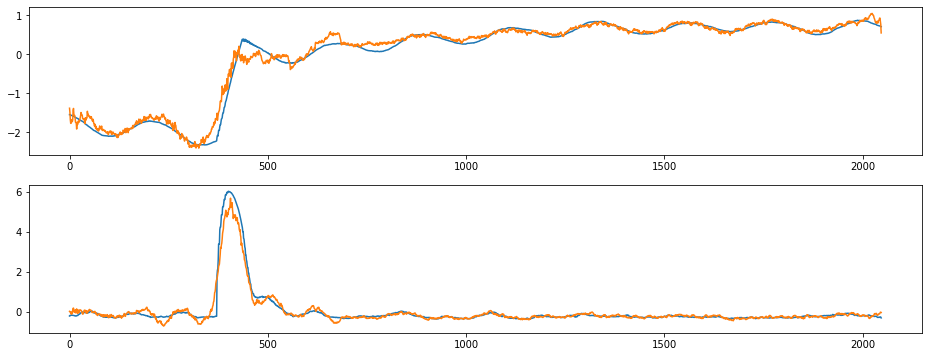

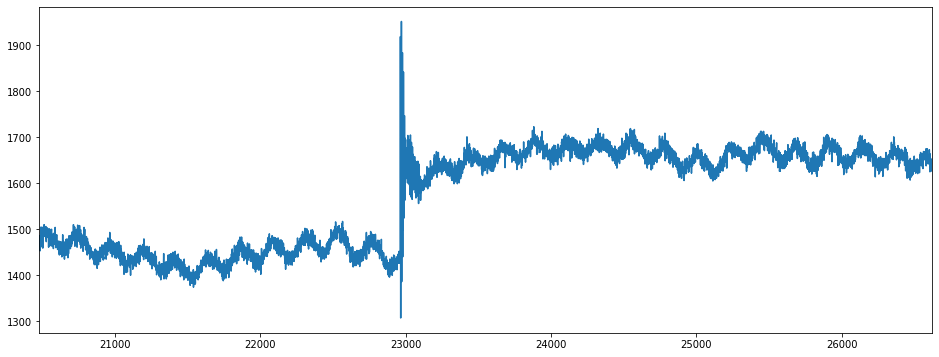

index:  187956
MAE:  0.09940694587999352
n_bunches        924
bunch_index     1178
bunch_number     843
chunk              0
Name: 240, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6703/instability_data/06703_Inst_B1H_Q7_20180520_03h44m14s.h5


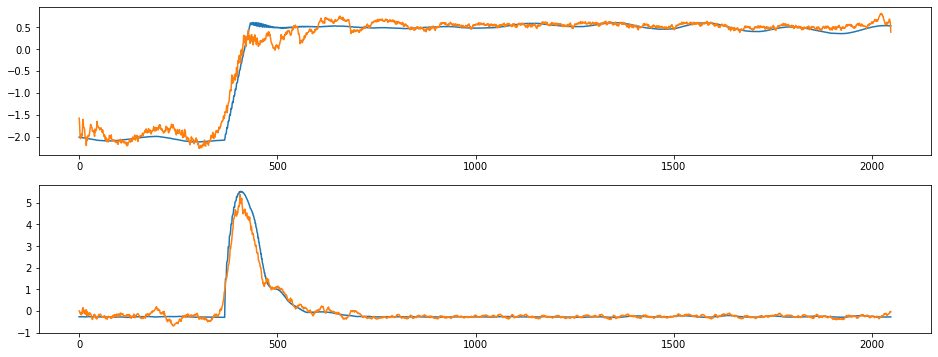

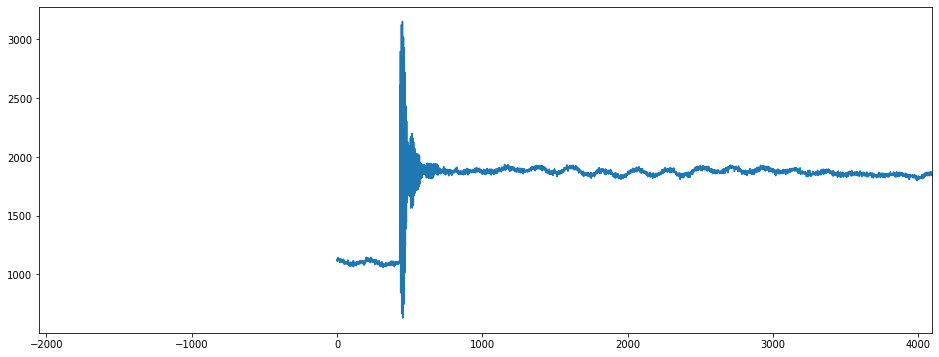

index:  90639
MAE:  0.09903212351406165
n_bunches        908
bunch_index     1415
bunch_number     783
chunk             10
Name: 2764, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6252/instability_data/06252_Inst_B1H_Q7_20170927_21h30m35s.h5


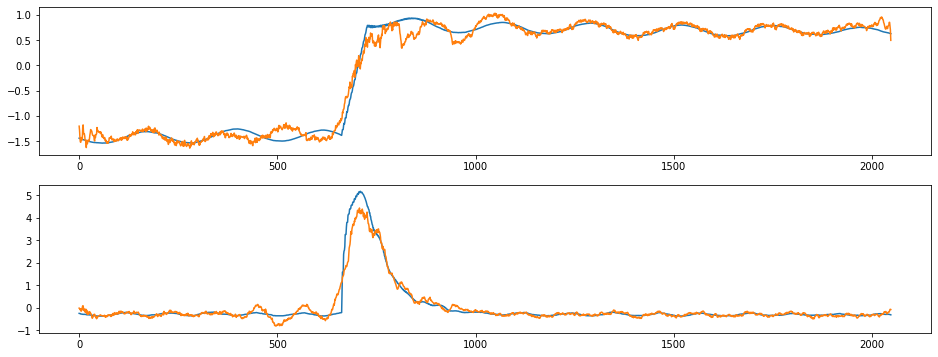

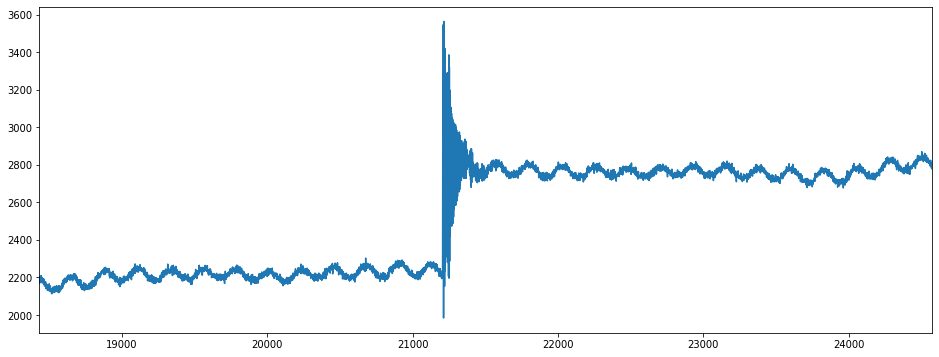

index:  24437
MAE:  0.1014567209837541
n_bunches       540
bunch_index     540
bunch_number    375
chunk            12
Name: 3300, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_03h01m50s.h5


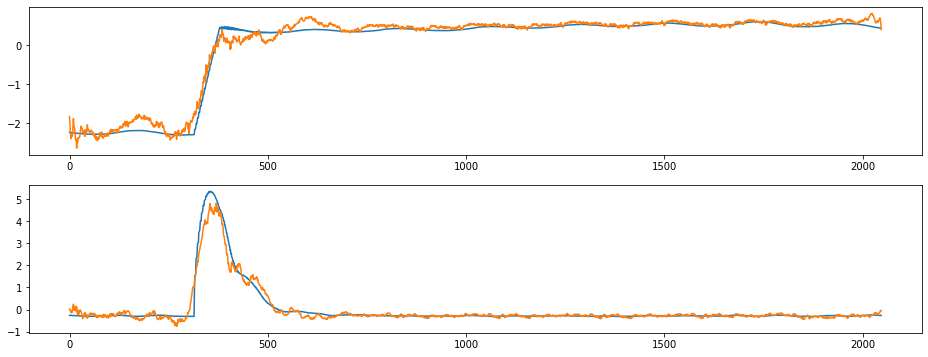

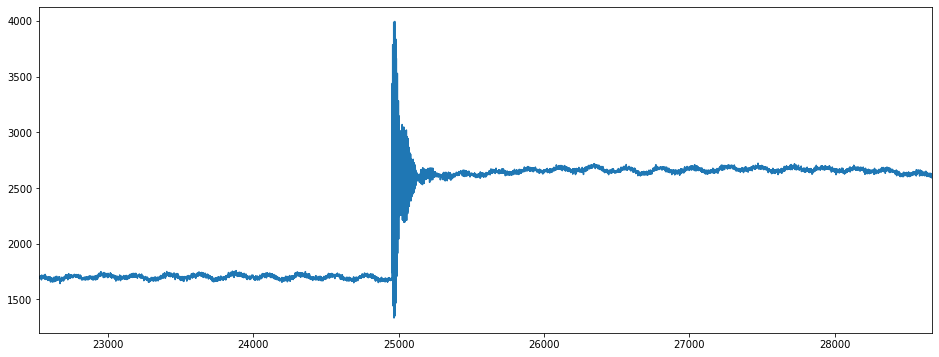

index:  236483
MAE:  0.10192290053026716
n_bunches        408
bunch_index     2269
bunch_number     388
chunk             20
Name: 5375, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_03h28m28s.h5


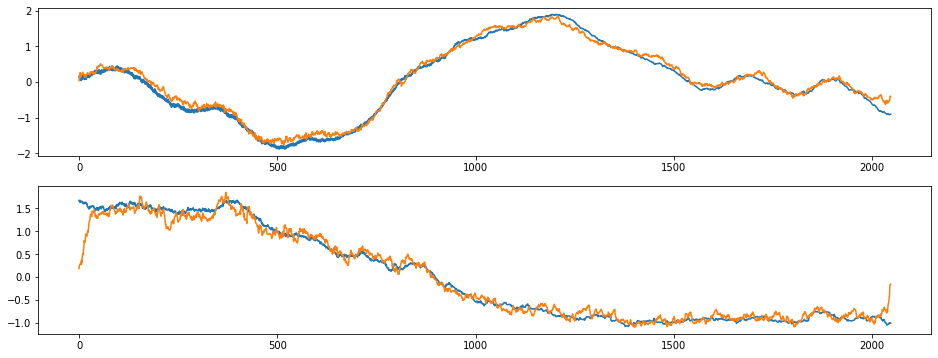

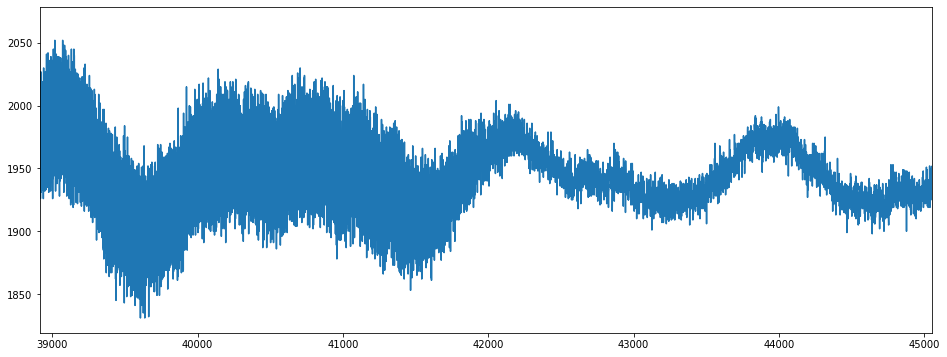

index:  212026
MAE:  0.10211741855338229
n_bunches       108
bunch_index      85
bunch_number     36
chunk             9
Name: 2346, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6957/instability_data/06957_Inst_B1H_Q7_20180721_22h24m52s.h5


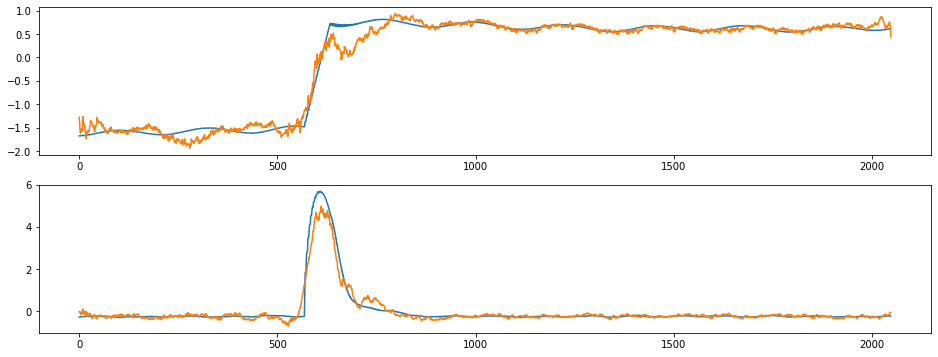

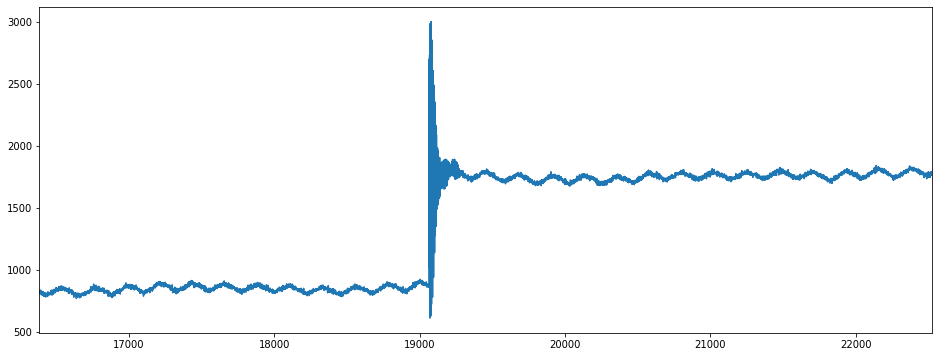

index:  89657
MAE:  0.10241465489527468
n_bunches       1868
bunch_index     3023
bunch_number    1617
chunk             22
Name: 5813, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6411/instability_data/06411_Inst_B1H_Q7_20171122_22h26m07s.h5


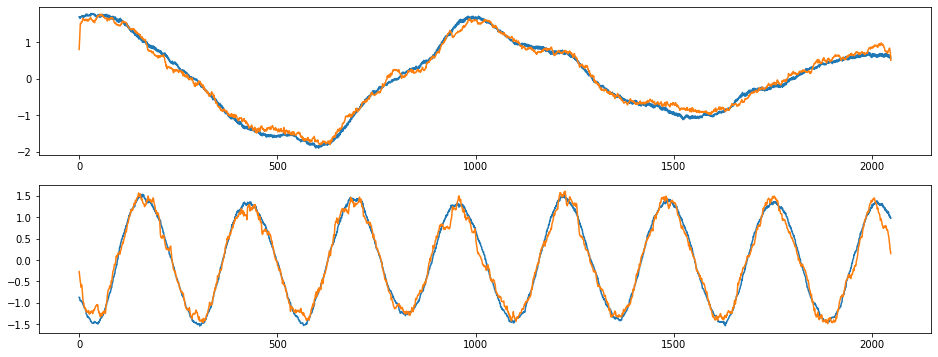

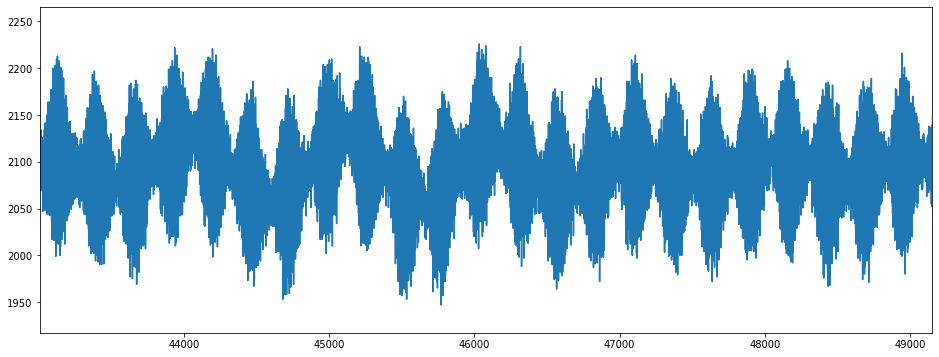

index:  291711
MAE:  0.102426960588926
n_bunches       108
bunch_index     118
bunch_number     49
chunk             4
Name: 1120, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h09m43s.h5


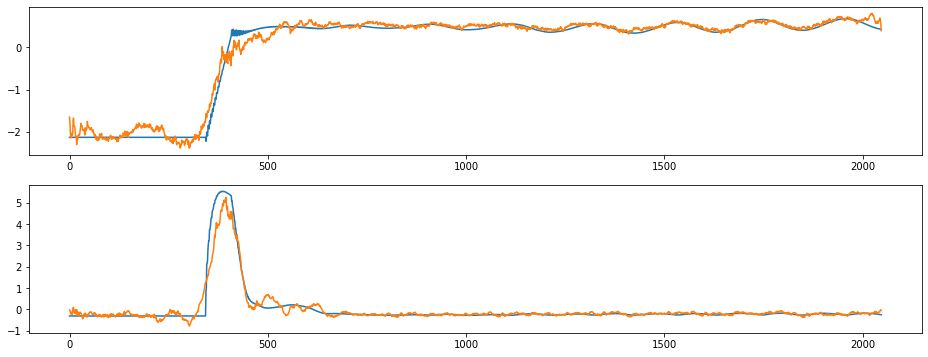

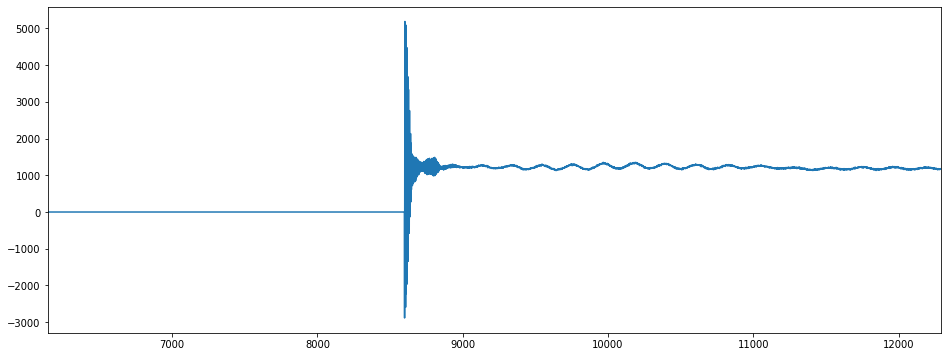

index:  65131
MAE:  0.10244529282862139
n_bunches        410
bunch_index     2138
bunch_number     377
chunk              9
Name: 2387, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7306/instability_data/07306_Inst_B1H_Q7_20181015_06h35m40s.h5


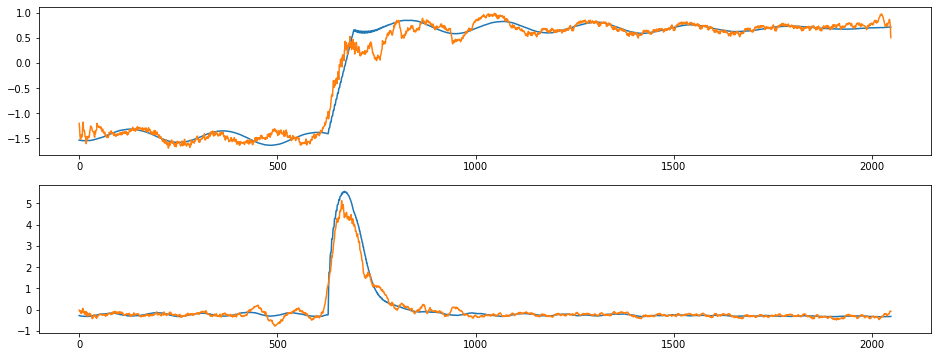

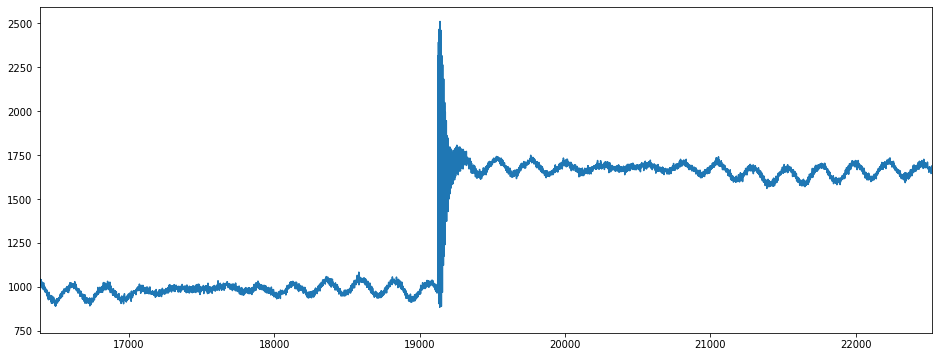

In [40]:
for i in range(10):
    index = around_point_indices[i]

    print('index: ', index)
    print("MAE: ", MAE_train[index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[index].squeeze()
    pred_signal = train_pred[index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

In [ ]:
break

# latent space encoding

In [ ]:
import keras

In [ ]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_3').output)

In [ ]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

In [ ]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

In [ ]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

In [ ]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Generating an latent space image dataset

In [ ]:
latent_dataset = []
latent_metadata = []
latent_input_data = []
for i in tqdm(range(65536)):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    input_data = train_dataset[anomalous_index][None, :]
    encoding_output = encoding_model(input_data)
    latent_dataset.append(encoding_output)
    latent_input_data.append(input_data)
    # get the metadata
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    latent_metadata.append(metadata_row)
#     break

latent_dataset = np.vstack(latent_dataset)
latent_input_data = np.vstack(latent_input_data)
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
model_latent_space_folder = latent_space_folder / model_path.name
model_latent_space_file = model_latent_space_folder / f'latent_space_{latent_dataset.shape[0]}.npy'
model_latent_space_metadata_file = model_latent_space_folder / f'metadata_latent_space_{latent_dataset.shape[0]}.h5'
model_train_dataset_file = model_latent_space_folder / f'train_dataset_{train_dataset.shape[0]}.npy'
model_latent_input_file = model_latent_space_folder/ f"latent_input_{latent_input_data.shape[0]}.npy"
model_train_max_MAE_file = model_latent_space_folder / f'train_max_MAE_{max_MAE_indices.shape[0]}.npy'

In [ ]:
if not model_latent_space_folder.is_dir():
    model_latent_space_folder.mkdir()

In [ ]:
np.save(model_latent_space_file, latent_dataset)

In [ ]:
latent_metadata.to_hdf(model_latent_space_metadata_file, 'data')

In [ ]:
np.save(model_train_dataset_file, train_dataset)

In [ ]:
np.save(model_train_max_MAE_file, max_MAE_indices)

In [ ]:
np.save(model_latent_input_file, latent_input_data)